# Volcanic Rock Voucher - Volatility Strategy Research
This notebook computes mid-prices, premiums, implied volatility, and helps tune trading parameters for vouchers.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statistics import NormalDist

# Load CSVs (put them in the same folder as this notebook)
price_files = [
    "/users/eleves-b/2023/youssef.nakhla/imc/2025/prices_round_3_day_0.csv",
    "/users/eleves-b/2023/youssef.nakhla/imc/2025/prices_round_3_day_1.csv",
    "/users/eleves-b/2023/youssef.nakhla/imc/2025/prices_round_3_day_2.csv"
]
dfs = [pd.read_csv(f) for f in price_files]
prices = pd.concat(dfs, ignore_index=True)

# Parse semicolon-delimited format
df = prices.iloc[:, 0].str.split(";", expand=True)
df.columns = [
    "day", "timestamp", "product",
    "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
    "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
    "mid_price", "profit_and_loss"
]
numeric_cols = df.columns.difference(["day", "timestamp", "product"])
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df["timestamp"] = df["timestamp"].astype(int)


In [2]:
class BlackScholes:
    @staticmethod
    def call_price(S, K, T, vol):
        d1 = (math.log(S / K) + 0.5 * vol ** 2 * T) / (vol * math.sqrt(T))
        d2 = d1 - vol * math.sqrt(T)
        return S * NormalDist().cdf(d1) - K * NormalDist().cdf(d2)

    @staticmethod
    def implied_vol(market_price, S, K, T, tol=1e-5, max_iter=100):
        low, high = 0.01, 2.0
        for _ in range(max_iter):
            mid = (low + high) / 2
            price = BlackScholes.call_price(S, K, T, mid)
            if abs(price - market_price) < tol:
                return mid
            if price > market_price:
                high = mid
            else:
                low = mid
        return mid

    @staticmethod
    def delta(S, K, T, vol):
        d1 = (math.log(S / K) + 0.5 * vol ** 2 * T) / (vol * math.sqrt(T))
        return NormalDist().cdf(d1)


In [3]:
# Extract IV per voucher
vouchers = {
    "VOLCANIC_ROCK_VOUCHER_9500": 9500,
    "VOLCANIC_ROCK_VOUCHER_9750": 9750,
    "VOLCANIC_ROCK_VOUCHER_10000": 10000,
    "VOLCANIC_ROCK_VOUCHER_10250": 10250,
    "VOLCANIC_ROCK_VOUCHER_10500": 10500,
}
rock_df = df[df["product"] == "VOLCANIC_ROCK"]
results = []

for voucher, strike in vouchers.items():
    v_df = df[df["product"] == voucher]
    for t in sorted(df["timestamp"].unique()):
        r_row = rock_df[rock_df["timestamp"] == t]
        v_row = v_df[v_df["timestamp"] == t]
        if v_row.empty or r_row.empty:
            continue
        spot = r_row["mid_price"].values[0]
        bid = v_row["bid_price_1"].values[0]
        ask = v_row["ask_price_1"].values[0]
        premium = (bid + ask) / 2
        T = max(0.01, (7 - t // 100) / 7)
        try:
            iv = BlackScholes.implied_vol(premium, spot, strike, T)
            delta = BlackScholes.delta(spot, strike, T, iv)
            results.append({
                "timestamp": t,
                "voucher": voucher,
                "strike": strike,
                "premium": premium,
                "spot": spot,
                "iv": iv,
                "delta": delta,
                "T": T
            })
        except:
            continue

iv_df = pd.DataFrame(results)
iv_df.head()


,timestamp,voucher,strike,premium,spot,iv,delta,T
0,0,VOLCANIC_ROCK_VOUCHER_9500,9500,1003.5,10503.0,0.038108,0.996010,1.000000
1,100,VOLCANIC_ROCK_VOUCHER_9500,9500,1010.5,10510.0,0.041404,0.996034,0.857143
2,200,VOLCANIC_ROCK_VOUCHER_9500,9500,1013.5,10513.0,0.045469,0.996044,0.714286
3,300,VOLCANIC_ROCK_VOUCHER_9500,9500,1018.0,10517.5,0.051027,0.996059,0.571429
4,400,VOLCANIC_ROCK_VOUCHER_9500,9500,1010.0,10509.5,0.058529,0.996032,0.428571


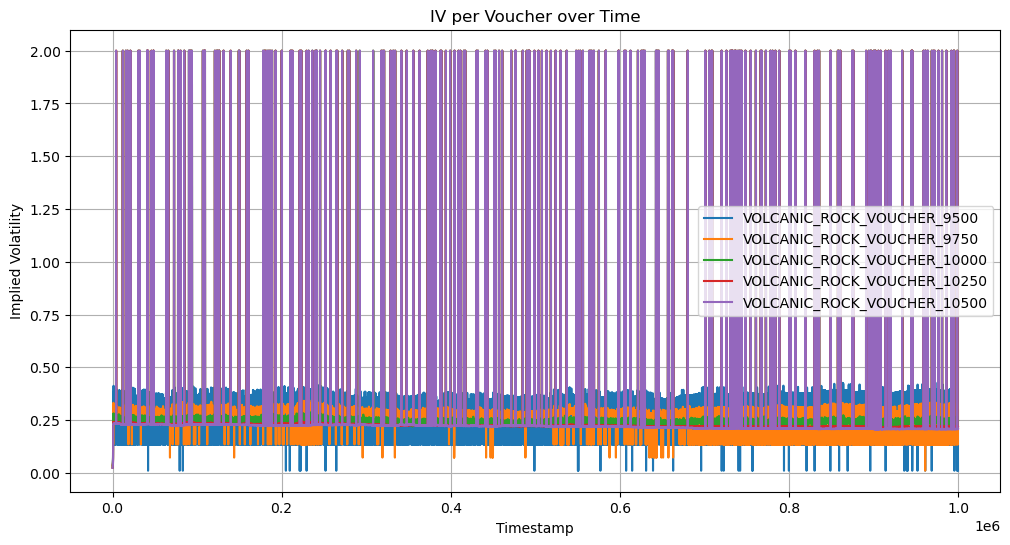

In [4]:
plt.figure(figsize=(12, 6))
for voucher in vouchers:
    plt.plot(iv_df[iv_df.voucher == voucher].timestamp, iv_df[iv_df.voucher == voucher].iv, label=voucher)
plt.xlabel("Timestamp")
plt.ylabel("Implied Volatility")
plt.title("IV per Voucher over Time")
plt.legend()
plt.grid(True)
plt.show()

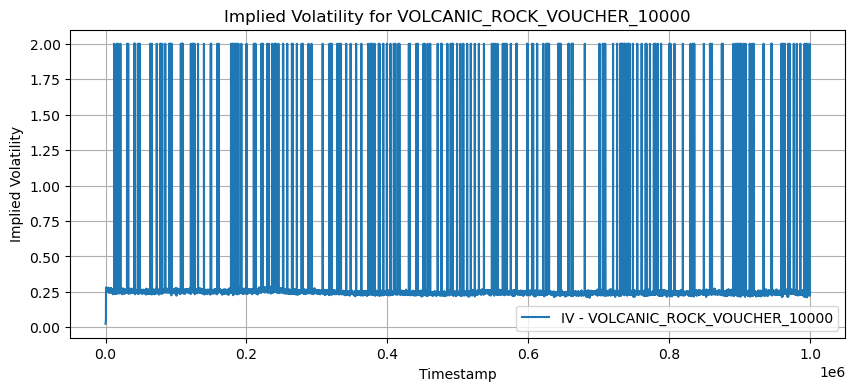

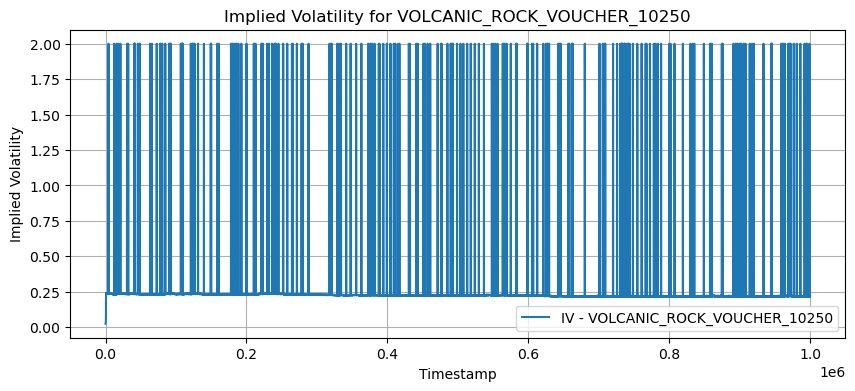

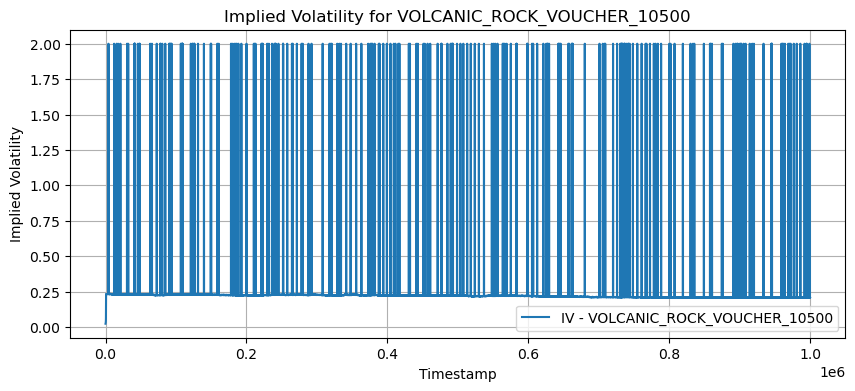

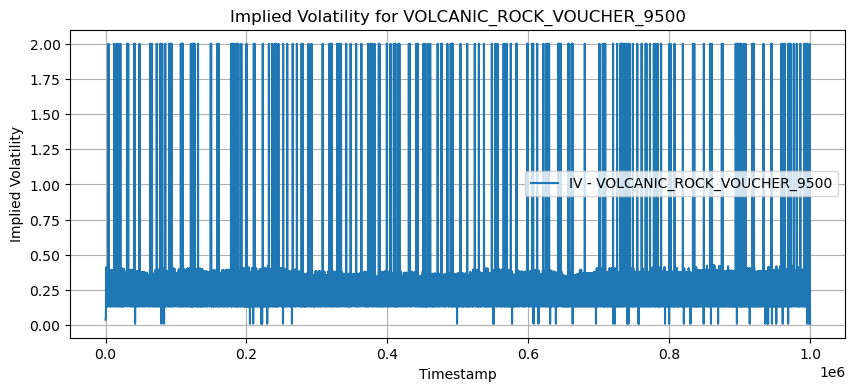

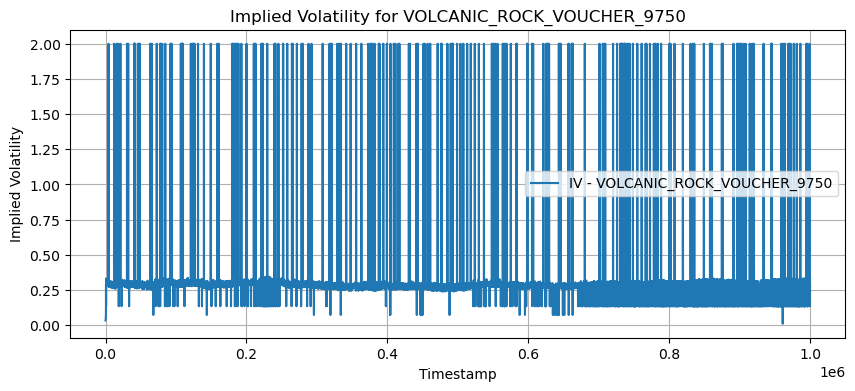

In [16]:
voucher_groups = iv_df.groupby("voucher")

for voucher, group in voucher_groups:
    plt.figure(figsize=(10, 4))
    plt.plot(group["timestamp"], group["iv"], label=f"IV - {voucher}")
    plt.title(f"Implied Volatility for {voucher}")
    plt.xlabel("Timestamp")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend()
    plt.show()

In [5]:
iv_df.groupby("voucher")[["iv"]].agg(["mean", "std"])

iv          
                                 mean       std
voucher                                        
VOLCANIC_ROCK_VOUCHER_10000  0.285861  0.260935
VOLCANIC_ROCK_VOUCHER_10250  0.264206  0.263488
VOLCANIC_ROCK_VOUCHER_10500  0.259504  0.265429
VOLCANIC_ROCK_VOUCHER_9500   0.305198  0.269924
VOLCANIC_ROCK_VOUCHER_9750   0.310515  0.254420

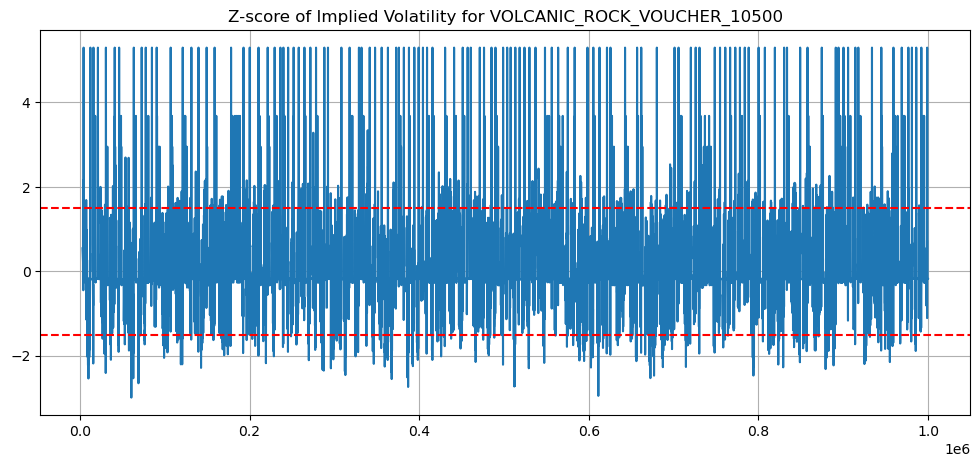

In [15]:
voucher = "VOLCANIC_ROCK_VOUCHER_10500"
window = 30
subset = iv_df[iv_df.voucher == voucher].copy()
subset["rolling_mean"] = subset["iv"].rolling(window).mean()
subset["rolling_std"] = subset["iv"].rolling(window).std()
subset["zscore"] = (subset["iv"] - subset["rolling_mean"]) / subset["rolling_std"]

plt.figure(figsize=(12,5))
plt.plot(subset["timestamp"], subset["zscore"])
plt.axhline(1.5, color="red", linestyle="--")
plt.axhline(-1.5, color="red", linestyle="--")
plt.title(f"Z-score of Implied Volatility for {voucher}")
plt.grid(True)
plt.show()

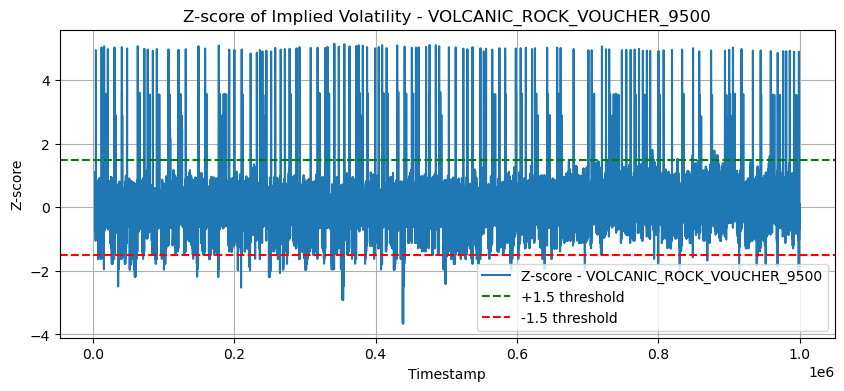

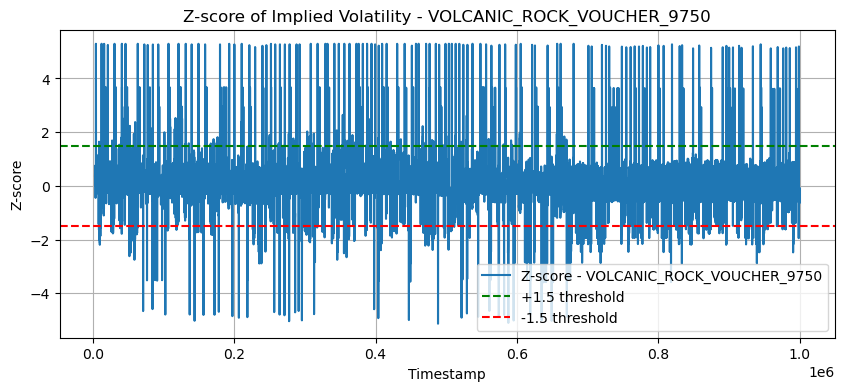

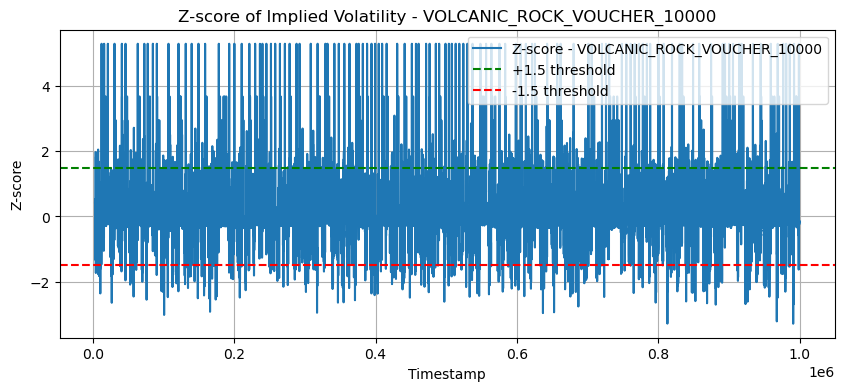

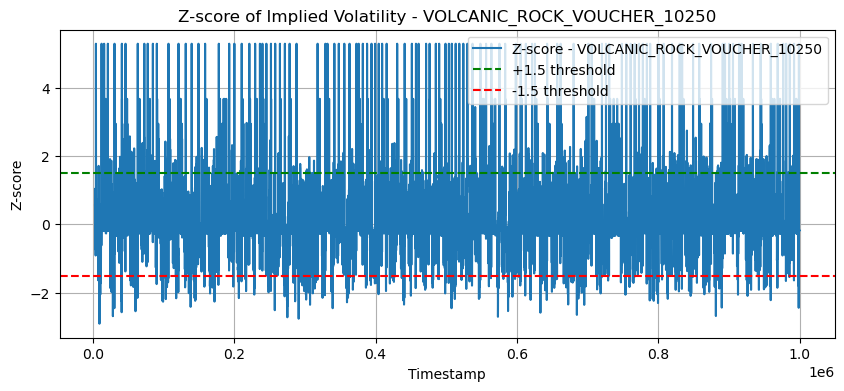

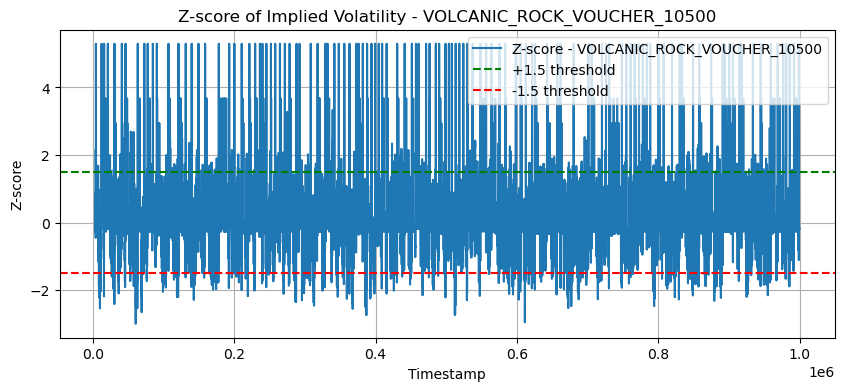

In [17]:
# Compute and plot z-scores for each voucher
rolling_window = 30

for voucher in iv_df["voucher"].unique():
    sub = iv_df[iv_df["voucher"] == voucher].copy()
    sub["rolling_mean"] = sub["iv"].rolling(rolling_window).mean()
    sub["rolling_std"] = sub["iv"].rolling(rolling_window).std()
    sub["zscore"] = (sub["iv"] - sub["rolling_mean"]) / sub["rolling_std"]

    plt.figure(figsize=(10, 4))
    plt.plot(sub["timestamp"], sub["zscore"], label=f"Z-score - {voucher}")
    plt.axhline(1.5, color="green", linestyle="--", label="+1.5 threshold")
    plt.axhline(-1.5, color="red", linestyle="--", label="-1.5 threshold")
    plt.title(f"Z-score of Implied Volatility - {voucher}")
    plt.xlabel("Timestamp")
    plt.ylabel("Z-score")
    plt.grid(True)
    plt.legend()
    plt.show()